In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
%matplotlib widget

f = pickle.load(open('G089.75_5.sav','rb')) 

Text(0.5, 0, '$V_{lsr}$')

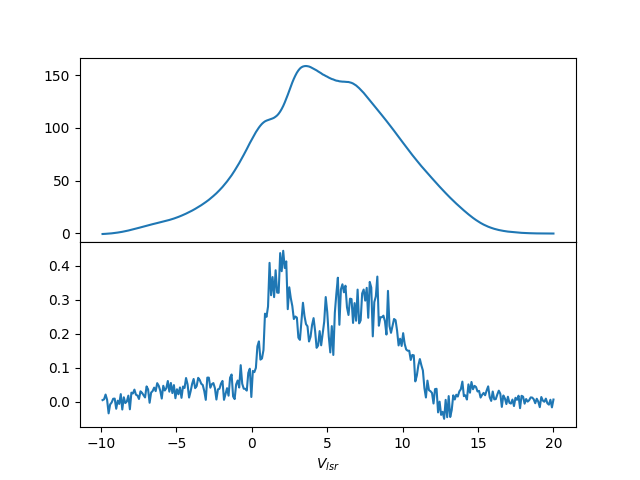

In [2]:
def gaussian(x,h,mu,sig):
    return h*np.exp(-np.power(x-mu,2.)/(2*np.power(sig,2.)))
#Read stokes
vel = f['vel1']
stk_i = f['stk_iall']
stk_q = f['stk_qall']
stk_u = f['stk_uall']
stk_v = f['stk_vall']
fig1,ax1 = plt.subplots(2,sharex=True,gridspec_kw={'hspace':0})
ax1[0].plot(vel,stk_i)
ax1[1].plot(vel,stk_v)
ax1[1].set_xlabel(r'$V_{lsr}$')

In [3]:
from lmfit import Minimizer,Parameters
#define class for stokes I
class component:
    def __init__(self,type,id):
        pass
        self.type = type
        self.id = id
    def getParams(self,params):
        id = self.id
        self.c =params[f'c{id}']
        self.w =params[f'w{id}']
        if self.type != "HINSA":
            self.h =params[f'h{id}']
        if self.type != "WNM":
            self.t =params[f't{id}']

    def print_params(self):
        print(f'c={self.c}')
        print(f'w={self.w}')
        if self.type != "HINSA":
            print(f'h={self.h}')
        if self.type != "WNM":
            print(f't={self.t}')

    def passthrough(self,I,x,params):
        self.getParams(params)
        if self.type == "WNM":
            return I
        tau = gaussian(x,self.t,self.c,self.w)
        return I*np.exp(-tau)        
        
    
    def emit(self,x,params):
        self.getParams(params)
        if self.type == 'HINSA':
            return 0
        if self.type == 'WNM':
            return gaussian(x,self.h,self.c,self.w)
        if self.type == 'CNM':
            tau = gaussian(x,self.t,self.c,self.w)
            return self.h*(1-np.exp(-tau))
        

class stokes_I:
    def __init__(self,x,stk_i):
        self.params = Parameters()
        self.cnmCount = 0
        self.wnmCount = 0
        self.hinsaCount = 0
        self.x = x
        self.stk_i = stk_i
        self.components = {}
    
    def addCNM(self,id,props,vary=[True,True,True,True],
               lbound=[None,None,None,None],
               ubound=[None,None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that CNM to the model
        '''
        print(id)
        self.cnmCount += 1
        self.params.add_many((f'h{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f't{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'c{id}',props[2],vary[2],lbound[2],ubound[2],None,None),
                             (f'w{id}',props[3],vary[3],lbound[3],ubound[3],None,None))

        self.components[id] = component('CNM',id)


    def addWNM(self,id,props,vary=[True,True,True],
               lbound=[None,None,None],
               ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that WNM to the model
        '''
        self.wnmCount += 1
        self.params.add_many((f'h{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f'c{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'w{id}',props[2],vary[2],lbound[2],ubound[2],None,None))
        self.components[id] = component('WNM',id)
        

    def addHINSA(self,id,props,vary=[True,True,True],
                 lbound=[None,None,None],
                 ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds HINSA to the model
        '''
        self.params.add_many((f't{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f'c{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'w{id}',props[2],vary[2],lbound[2],ubound[2],None,None))
        self.hinsaCount += 1
        self.components[id] = component('HINSA',id)

    def performFit(self,order):
        self.order = order
        fitter = Minimizer(self.fitfunc,self.params)
        self.result = fitter.minimize(method='leastsq')

    def fitfunc(self,params):
        model = self.stokesI(params)
        return abs(self.stk_i-model)

    def stokesI(self,params):
        order = self.order
        x = self.x
        #Calculate tau for each component
        #Calculate Tc based on the oredering
        tot = 0
        for n,i in enumerate(order):
            comp = self.components[i]
            I = comp.emit(x,params)
            for j in order[:n]:
                comp_ = self.components[j]
                I = comp_.passthrough(I,x,params)
            tot+=I
        ret = tot
        
        return ret

    def plot(self,ax):
        I_tot = 0
        I_noHINSA_tot = 0
        ax.plot(self.x,self.stk_i)
        for n,id in enumerate(self.order):
            comp = self.components[id]
            if comp.type == 'HINSA':
                continue
            print(comp.type,comp.id)
            
            I = comp.emit(self.x,self.result.params)
            I_noHINSA = I
            for j in self.order[:n]:
                comp_ = self.components[j]
                if comp_.type != 'HINSA':
                    I_noHINSA = comp_.passthrough(I_noHINSA,self.x,self.result.params)
                I = comp_.passthrough(I,self.x,self.result.params)
            ax.plot(self.x,I_noHINSA,label=id)
            I_tot += I
            I_noHINSA_tot += I_noHINSA
        ax.plot(self.x,I_tot,label='fit')
        ax.plot(self.x,I_noHINSA_tot-I_tot,label = 'HINSA')
        ax.legend()

                


        
        





In [4]:
#define class for stokes V
class stokes_V:
    def __init__(self,stokesIModel,stk_v):
        self.Iparams = stokesIModel.result.params
        self.wnmCount = stokesIModel.wnmCount
        self.cnmCount = stokesIModel.cnmCount
        self.totComp = self.wnmCount + self.cnmCount + 1
        self.stk_i = stokesIModel.stk_i
        self.x = stokesIModel.x
        self.stk_v = stk_v
        self.order = stokesIModel.order
    
    def addParams(self,vals,vary=None,
                  lbound=None,
                  ubound=None):
        
        if len(vals) < self.totComp + 1:
            print(self.cnmCount)
            print(self.wnmCount)
            raise RuntimeError(f"""Please pass values for all components. 
                               You passed {len(vals)} values, while {self.totComp+1} were expected. 
                               Remember to pass a value for leakage too!""")
        
        if vary == None:
            vary = [True]*(self.totComp+1)
        if lbound == None:
            vary = [None]*(self.totComp+1)
        if ubound == None:
            vary = [None]*(self.totComp+1)
        
        self.params = Parameters()
        print(vals,vals[0])
        self.params.add(f'b0',vals[0],vary[0],lbound[0],ubound[0],None,None)
        for i in range(self.cnmCount):
            self.params.add(f'b{i+1}',vals[i+1],vary[i+1],lbound[i+1],ubound[i+1],None,None)
        for i in range(self.wnmCount):
            j = self.cnmCount + i + 1
            self.params.add(f'bw{i+1}',vals[j],vary[j],lbound[j],ubound[j],None,None)
        
        self.params.add('c',vals[j+1],vary[j+1],lbound[j+1],ubound[j+1])
        
        
    def performFit(self):
        fitter = Minimizer(self.fitfunc,self.params)
        self.result = fitter.minimize(method='leastsq')

    def fitfunc(self,params):
        data = self.stk_v
        model = self.stokesV(params)
        return abs(data-model)
        
    def stokesV(self,params,ax=[]):
        Iparams = self.Iparams
        x = self.x
        stk_i = self.stk_i
        stk_v = self.stk_v
        order = self.order

        tau = np.zeros(shape=(self.cnmCount+1,2,len(x)))
        Tc = np.empty(shape=(self.cnmCount,2,len(x)))
        Tw = np.empty(shape=(self.wnmCount,2,len(x)))

        #Calculate tau for each component
        #Calculate Tc based on the oredering
        for n,i in enumerate(order):
            tau_cur_RCP = gaussian(x,Iparams[f't{i}'],Iparams[f'c{i}']+params[f'b{i}'],Iparams[f'w{i}'])
            tau_cur_LCP = gaussian(x,Iparams[f't{i}'],Iparams[f'c{i}']-params[f'b{i}'],Iparams[f'w{i}'])
            tau[i,0] = tau_cur_RCP
            tau[i,1] = tau_cur_LCP
            if i != 0:
                Tc_cur_RCP = 0.5*Iparams[f'h{i}']*(1-np.exp(-tau_cur_RCP))*np.exp(-np.sum(tau[order[:n],0],axis=0))
                Tc_cur_LCP = 0.5*Iparams[f'h{i}']*(1-np.exp(-tau_cur_LCP))*np.exp(-np.sum(tau[order[:n],1],axis=0))
                Tc[i-1,0] = Tc_cur_RCP
                Tc[i-1,1] = Tc_cur_LCP

        tau_tot_RCP = np.sum(tau,axis=0)[0]
        tau_tot_LCP = np.sum(tau,axis=0)[1]
        
        #Calcuate all wnm profiles
        for i in range(self.wnmCount):
            Tw_cur_RCP = np.exp(-tau_tot_RCP)*gaussian(vel,Iparams[f'hw{i+1}']/2,Iparams[f'cw{i+1}']+params[f'bw{i+1}'],Iparams[f'ww{i+1}'])
            Tw_cur_LCP = np.exp(-tau_tot_LCP)*gaussian(vel,Iparams[f'hw{i+1}']/2,Iparams[f'cw{i+1}']-params[f'bw{i+1}'],Iparams[f'ww{i+1}'])
            Tw[i,0] = Tw_cur_RCP
            Tw[i,1] = Tw_cur_LCP

        Tc_tot_RCP = np.sum(Tc,axis=0)[0]
        Tc_tot_LCP = np.sum(Tc,axis=0)[1]
        Tw_tot_RCP = np.sum(Tw,axis=0)[0]
        Tw_tot_LCP = np.sum(Tw,axis=0)[1]
        
        tot_v = (Tc_tot_RCP + Tw_tot_RCP) - (Tc_tot_LCP + Tw_tot_LCP)
        ret = tot_v + params['c']*stk_i
        if len(ax)!=0:
            ax[0].step(x,stk_v-params['c']*stk_i)
            ax[0].plot(x,tot_v,'r-',label='fit')
            for i in range(self.wnmCount):
                ax[0].plot(x,Tw[i,0] - Tw[i,1],label=f'WNM{i+1}',linestyle='--')
            for i in range(self.cnmCount):
                ax[0].plot(x,Tc[i,0] - Tc[i,1],label=f'CNM{i+1}',linestyle='--')
            ax[1].step(x,stk_v-ret)
            ax[1].axhline(0,color='k')

        self.tau = tau
        self.Tc = Tc
        self.Tw = Tw
        self.residual = self.stk_v - tot_v - params['c']*stk_i
        return ret
    
    def plot(self,components=False,op_depth=False):
        if not components:
            fig,ax = plt.subplots(2,sharex=True,gridspec_kw={'hspace':0},figsize=(8,4))
            self.stokesV(self.result.params,ax = ax)
            box = ax[0].get_position()
            ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            box = ax[1].get_position()
            ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
            
        else:
            fig,ax = plt.subplots(self.totComp,sharex=True,gridspec_kw={'hspace':0},figsize=(6,self.totComp*2))
            self.components(ax,op_depth)

    def components(self,ax,op_depth=False):
        x = self.x
        stk_v = self.stk_v
        stk_i = self.stk_i
        Vparams = self.result.params
        res = self.residual

        dvdf = 2.9979e5/1420.40575e6
        zf = 2.8

        B = np.empty(shape=(self.cnmCount+self.wnmCount+1))
        Berr = np.empty(shape=(self.cnmCount+self.wnmCount+1))
        ax[0].set_xlim(-10,20)


        
        for i in range(self.cnmCount):
            B[i+1] = round(Vparams[f'b{i+1}']/dvdf*2/zf,1)
            Berr[i+1] = round(Vparams[f'b{i+1}'].stderr/dvdf*2/zf,1)
            if not op_depth:
                h,t,c,w = self.Iparams[f'h{i+1}'],self.Iparams[f't{i+1}'],self.Iparams[f'c{i+1}'],self.Iparams[f'w{i+1}']
                RCP = h/2*(1-np.exp(-gaussian(self.x,t,c+Vparams[f'b{i+1}'],w)))
                LCP = h/2*(1-np.exp(-gaussian(self.x,t,c-Vparams[f'b{i+1}'],w)))
                self.plotComponent(ax[i+1],res,RCP-LCP,text=rf'CNM{i+1}=${B[i+1]}\pm{Berr[i+1]}$')

        for i in range(self.wnmCount):
            B[self.cnmCount+i+1] = round(Vparams[f'bw{i+1}']/dvdf*2/zf,1)
            Berr[self.cnmCount+i+1] = round(Vparams[f'bw{i+1}'].stderr/dvdf*2/zf,1)
            if not op_depth:
                h,c,w = self.Iparams[f'hw{i+1}'],self.Iparams[f'cw{i+1}'],self.Iparams[f'ww{i+1}']
                RCP = gaussian(self.x,h/2,c+Vparams[f'bw{i+1}'],w)
                LCP = gaussian(self.x,h/2,c-Vparams[f'bw{i+1}'],w)
                self.plotComponent(ax[i+self.cnmCount+1],res,RCP-LCP,text=rf'WNM{i+1}=${B[i+self.cnmCount+1]}\pm{Berr[i+self.cnmCount+1]}$')
            
        B[0] = round(Vparams['b0']/dvdf*2/zf,1)
        Berr[0] = round(Vparams['b0'].stderr/dvdf*2/zf,1)
        HINSA = self.calcHINSA(ax,op_depth,B,Berr)
        self.plotComponent(ax[0],res,HINSA,text=rf'HINSA=${B[0]}\pm{Berr[0]}$')

    def plotComponent(self,ax,res,y,text=None,color='r',label=None):
        ax.step(self.x,res+y,color='k',linewidth=0.5)
        ax.text(-10,0.1,text)
        ax.plot(self.x,y,color=color,label=label)
    
    def calcHINSA(self,ax,op_depth=False,B=None,Berr=None):
        Tc = self.Tc
        Tw = self.Tw
        x = self.x
        order = self.order
        res = self.residual
        noHINSA = np.empty(shape = (self.cnmCount+self.wnmCount,len(x)))
        tau0 = self.tau[0]
        j = 0
        for i in order[:order.index(0)]:
            y = Tc[i-1,0] - Tc[i-1,1]
            noHINSA[i-1] = y
            if op_depth:
                self.plotComponent(ax[j+1],res,y,text=rf'CNM{j+1}=${B[j+1]}\pm{Berr[j+1]}$')
            j+=1

        for i in order[order.index(0)+1:]:
            y = Tc[i-1,0]*np.exp(tau0[0]) -Tc[i-1,1]*np.exp(tau0[1])
            noHINSA[i-1] = y
            if op_depth:
                self.plotComponent(ax[j+1],res,y,text=rf'CNM{j+1}=${B[j+1]}\pm{Berr[j+1]}$')
            j+=1

        for i in range(self.wnmCount):
            y = Tw[i,0]*np.exp(tau0[0]) - Tw[i,1]*np.exp(tau0[1])
            noHINSA[self.cnmCount+i] = y
            if op_depth:
                self.plotComponent(ax[i+self.cnmCount+1],res,y,text=rf'WNM{i+1}=${B[i+self.cnmCount+1]}\pm{Berr[i+self.cnmCount+1]}$')

        RCP = (np.sum(Tc[:,0],axis=0) + np.sum(Tw[:,0],axis=0))
        LCP = (np.sum(Tc[:,1],axis=0) + np.sum(Tw[:,1],axis=0))
        HINSA = (RCP-LCP) - np.sum(noHINSA,axis=0)

        return HINSA
        

        


In [5]:
#Define number of cnm and wnm components and their starting parameters


stokesIModel = stokes_I(vel,stk_i)

stokesIModel.addCNM('C1',
             [75,2,3.1,1.46],
             [True,True,True,True],
             [0,0.1,-20,0],
             [300,10,20,2.3])

stokesIModel.addCNM('C2',
             [126.82,1.02,10.33,1],
             [True,True,True,True],
             [20,0.05,9,0],
             [300,10,20,2.5])

stokesIModel.addCNM('C3',
             [120,3,8.01,1.5],
             [True,True,True,True],
             [0,0,6,0],
             [200,100,9,2])

stokesIModel.addWNM('W1',
             [12,5,6],
             [True,True,True,True],
             [0,-4,0],
             [100,15,10])

stokesIModel.addHINSA('H1',
                      [0.1,1.89,1],
                      [True,True,True],
                      [0,1.5,0],
                      [100,2,2])
#Define order
order = ['H1','C1','C2','C3','W1']


"""stokesIModel.addCNM([75,2,3.1,1.46],
             [True,True,True,True],
             [0,0.1,-20,0],
             [300,10,20,2.3])

stokesIModel.addCNM([126.82,1.02,10.33,1],
             [True,True,True,True],
             [20,0.05,9,0],
             [300,10,20,2.5])

stokesIModel.addCNM([120,3,8.01,1.5],
             [True,True,True,True],
             [0,0,6,0],
             [200,100,9,2])

stokesIModel.addWNM([12,5,6],
             [True,True,True,True],
             [0,-4,0],
             
             [100,15,10])

stokesIModel.addHINSA([0.1,1.89,1],
                      [True,True,True],
                      [0,1.5,0],
                      [100,2.0,2.0])
order = [0,1,2,3,4]"""
#2134
stokesIModel.performFit(order = order)
print(stokesIModel.result.message)
display(stokesIModel.result.params)

C1
C2
C3
Fit succeeded.


name,value,standard error,relative error,initial value,min,max,vary
hC1,299.996182,129.370673,(43.12%),75,0.00000000,300.000000,True
tC1,0.22536779,0.14213505,(63.07%),2,0.10000000,10.0000000,True
cC1,1.69634120,0.19027212,(11.22%),3.1,-20.0000000,20.0000000,True
wC1,1.58730040,0.05966632,(3.76%),1.46,0.00000000,2.30000000,True
hC2,52.6888577,1.52145861,(2.89%),126.82,20.0000000,300.000000,True
tC2,1.18712358,0.02632620,(2.22%),1.02,0.05000000,10.0000000,True
cC2,11.2543755,0.04720973,(0.42%),10.33,9.00000000,20.0000000,True
wC2,1.87168122,0.02801276,(1.50%),1,0.00000000,2.50000000,True
hC3,145.649707,0.57898926,(0.40%),120,0.00000000,200.000000,True
tC3,13.4586261,3.49138276,(25.94%),3,0.00000000,100.000000,True


CNM C1
CNM C2
CNM C3
WNM W1


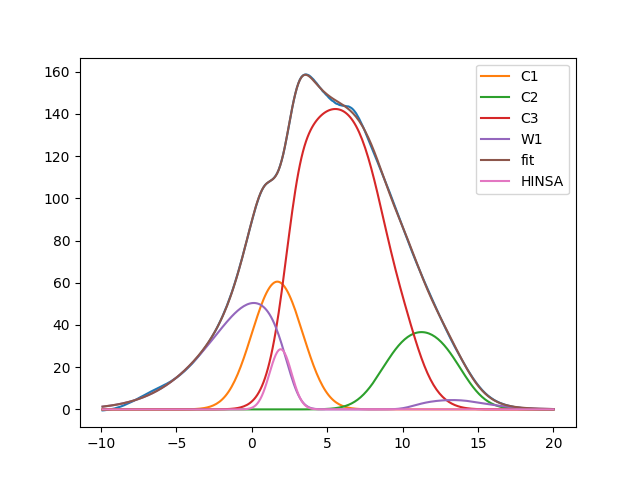

In [6]:
fig,ax = plt.subplots(1)
stokesIModel.plot(ax)

In [7]:
stkVModel = stokes_V(stokesIModel,stk_v)
stkVModel.addParams([0.02,-0.01,0.01,0.002,0.01,0.05,0.00034],
                    [True,True,True,True,True,True,True],
                    [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,0],
                    [0.1,0.1,0.1,0.1,0.1,0.1,1e-2])

stkVModel.performFit()
print(stkVModel.result.message)
display(stkVModel.result.params)

[0.02, -0.01, 0.01, 0.002, 0.01, 0.05, 0.00034] 0.02


KeyError: 'bH1'

In [ ]:
stkVModel.plot()

In [ ]:
stkVModel.plot(True)